<a href="https://colab.research.google.com/github/Lughaide/NCKH_SDR_HumanDetection/blob/main/Wireless_Detection_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Processing

## Loading data from Drive

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Adding path
root_path = '/content/drive/MyDrive/CSI_Data/CSI_Data'

In [ ]:
!ls $root_path

csiview.py  Empty  Lab_floorplan.png  Presence	Presence_Cleaned  runscript.py


## CSI Data plotting

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_csi_data(csi_data):
  plt.figure()
  plt.title("CSI data")
  plt.plot(csi_data)
  plt.show()

## Creating Train/Test dataset

In [ ]:
# Importing needed libraries
import os
import numpy as np

In [ ]:
# Creating arrays: Detection
train_labels_DT = []
train_samples_DT = []

test_labels_DT = []
test_samples_DT = []

# Creating arrays: Localization
train_labels_LC = []
train_samples_LC = []

test_labels_LC = []
test_samples_LC = []

In [ ]:
# Creating temporary arrays
samples_temp_1 = []
labels_temp_1 = []

samples_temp_2 = []
labels_temp_2 = []

In [ ]:
# Removing unneeded subcarriers
sub_del = list(range(0, 6)) + [32] + list(range(59, 64))
sub_del

[0, 1, 2, 3, 4, 5, 32, 59, 60, 61, 62, 63]

### Data with no human presence

In [ ]:
# Setting path to folders
empty_raw = root_path+"/Empty/"

In [ ]:
# Preparing data
for count, filename in enumerate(os.listdir(empty_raw)):
  # Read each file as a numpy array
  f = np.fromfile(open(empty_raw + filename), dtype=np.complex64)

  # Reshape into suitable shape and remove subcarriers
  new_arr = abs(np.reshape(f, (-1, 64)))
  new_arr = np.delete(new_arr, sub_del, 1)

  # Reduce array size by 10
  new_arr = new_arr[0:len(new_arr):10]

  # Debug to check result
  # print(filename, ":", new_arr.shape)

  # Append to temp array
  for count2, data in enumerate(np.array_split(new_arr, 4)):
    # Detection data
    samples_temp_1.append(data)
    # Generating more data for detection: reversing existing data
    samples_temp_1.append(data[::-1])

    # Localization data
    samples_temp_2.append(data)
    # Generating more data for detection: reversing existing data
    samples_temp_2.append(data[::-1])

  # Adding labels: 0 is empty
    labels_temp_1.append(0)
    labels_temp_1.append(0)

    labels_temp_2.append(0)
    labels_temp_2.append(0)

### Data with human presence

In [ ]:
# Manually selecting folders for data
list_of_folders = ['Area1', 'Area2', 'Area3', 'Area4', 'Area5', 'Area6']
list_of_folders

['Area1', 'Area2', 'Area3', 'Area4', 'Area5', 'Area6']

In [ ]:
# Setting paths to folders
human_raw = root_path+"/Presence_Cleaned/Presence_Data/"

In [ ]:
# Creating merged areas
def define_zones(foldername):
  return {
      'Area1': 1, 'Area2': 2,
      'Area3': 1, 'Area4': 2,
      'Area5': 1, 'Area6': 2
  }.get(foldername, -1)

In [ ]:
# Using clean data
# # Preparing data
for foldername in os.listdir(human_raw):
  if os.path.isdir(human_raw+foldername):
    if foldername in list_of_folders:
      print("-- Getting data from folder: " + foldername)
      for count, filename in enumerate(os.listdir(human_raw+foldername)):
        # Read each file as a numpy array
        data = np.load(human_raw + foldername + "/" + filename)
        # Reduce array size by 10
        data = data[0:len(data):10]

        # Detection data
        samples_temp_1.append(data)
        labels_temp_1.append(1)

        # Localization data
        samples_temp_2.append(data)
        labels_temp_2.append(define_zones(foldername))

-- Getting data from folder: Area1
-- Getting data from folder: Area3
-- Getting data from folder: Area2
-- Getting data from folder: Area5
-- Getting data from folder: Area6
-- Getting data from folder: Area4


## Checking dataset size & convert to numpy array

In [ ]:
# Checking size of dataset
# Detection
print(len(samples_temp_1))
print(len(labels_temp_1))

# Localization
print(len(samples_temp_2))
print(len(labels_temp_2))

680
680
680
680


In [ ]:
# Convert array to numpy array
temp_samples_1 = np.array(samples_temp_1)
temp_labels_1 = np.array(labels_temp_1)

temp_samples_2 = np.array(samples_temp_2)
temp_labels_2 = np.array(labels_temp_2)

In [ ]:
# Checking array shapes
print(temp_samples_1.shape, temp_labels_1.shape)
print(temp_samples_2.shape, temp_labels_2.shape)

# Format: 
#   samples: (sample_count, time_stamp, subcarrier_count)
#   labels: (label)

(680, 256, 52) (680,)
(680, 256, 52) (680,)


In [ ]:
# Setting input size for machine learning model input
input_size = (temp_samples_1.shape[1], temp_samples_1.shape[2])
print(input_size)

(256, 52)


## Splitting Train/Test dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Creating dataset for both models. Ratio: 80/20, random state: 42
train_samples_DT, test_samples_DT, train_labels_DT, test_labels_DT = train_test_split(temp_samples_1, temp_labels_1, test_size=0.20, random_state=42)
train_samples_LC, test_samples_LC, train_labels_LC, test_labels_LC = train_test_split(temp_samples_2, temp_labels_2, test_size=0.20, random_state=42)

In [ ]:
# Checking dataset size
print(len(train_labels_DT))
print(len(test_labels_DT))

print(len(train_labels_LC))
print(len(test_labels_LC))

544
136
544
136


In [ ]:
# Detection: Label mapping: {0: 'Empty', 1: 'Human'}
print('Total 0 training labels: ', np.count_nonzero(train_labels_DT == 0))
print('Total 1 training labels: ', np.count_nonzero(train_labels_DT == 1))

print('Total 0 testing labels: ', np.count_nonzero(test_labels_DT == 0))
print('Total 1 testing labels: ', np.count_nonzero(test_labels_DT == 1))

Total 0 training labels:  189
Total 1 training labels:  355
Total 0 testing labels:  59
Total 1 testing labels:  77


In [ ]:
# Localization: Label mapping: {0: 'Empty', 1: 'Human in zone 1', 2: 'Human in zone 2'}
for i in range(len(np.unique(train_labels_LC))):
  print('Total ', i, ' training labels: ', np.count_nonzero(train_labels_LC == i))

for i in range(len(np.unique(test_labels_LC))):
  print('Total ', i, ' testing labels: ', np.count_nonzero(test_labels_LC == i))

Total  0  training labels:  189
Total  1  training labels:  170
Total  2  training labels:  185
Total  0  testing labels:  59
Total  1  testing labels:  46
Total  2  testing labels:  31


# Threshold Algorithm

In [ ]:
from sklearn import preprocessing

In [ ]:
# Get data
detection_data = np.array(samples_temp_1)
detection_label = np.array(labels_temp_1)

In [ ]:
# Calculating empty data threshold
empty_thresh = 0
for i in range(len(detection_label)):
  diff_val = np.max(detection_data[i]) - np.min(detection_data[i])
  if (detection_label[i] == 0):
    empty_thresh += diff_val
empty_thresh = empty_thresh / np.count_nonzero(detection_label == 0)
print(empty_thresh)

0.23388667644992953


In [ ]:
temp_calc = []
for i in range(len(detection_label)):
  diff_val = np.max(detection_data[i]) - np.min(detection_data[i])
  if (diff_val > empty_thresh):
    temp_calc.append(1)
  else:
    temp_calc.append(0)

In [ ]:
detection_calc = np.array(temp_calc)

# Building Deep Learning model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, InputLayer
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import categorical_crossentropy

In [ ]:
# Utilizing GPU for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if (len(physical_devices) > 0):
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


In [ ]:
# Clear all model sessions
tf.keras.backend.clear_session()

## Detection model

In [ ]:
model = Sequential([
    InputLayer(input_shape=(input_size)),
    Dense(units=16, activation='relu'),
    Dense(units=32, activation='relu'),
    Flatten(),
    Dense(units=2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256, 16)           848       
                                                                 
 dense_1 (Dense)             (None, 256, 32)           544       
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 17,778
Trainable params: 17,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=Nadam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(
      x=train_samples_DT
    , y=train_labels_DT
    , validation_split=0.2 # takes 20% of training data to put as validation data
    , batch_size=5
    , epochs=30
    , verbose=2
)

Epoch 1/30
87/87 - 2s - loss: 0.6796 - accuracy: 0.6299 - val_loss: 0.6565 - val_accuracy: 0.6147 - 2s/epoch - 18ms/step
Epoch 2/30
87/87 - 0s - loss: 0.6422 - accuracy: 0.6529 - val_loss: 0.6885 - val_accuracy: 0.6147 - 288ms/epoch - 3ms/step
Epoch 3/30
87/87 - 0s - loss: 0.6085 - accuracy: 0.6644 - val_loss: 0.7258 - val_accuracy: 0.6147 - 250ms/epoch - 3ms/step
Epoch 4/30
87/87 - 0s - loss: 0.5723 - accuracy: 0.6506 - val_loss: 0.5617 - val_accuracy: 0.6147 - 258ms/epoch - 3ms/step
Epoch 5/30
87/87 - 0s - loss: 0.5333 - accuracy: 0.6897 - val_loss: 0.5150 - val_accuracy: 0.6147 - 289ms/epoch - 3ms/step
Epoch 6/30
87/87 - 0s - loss: 0.5109 - accuracy: 0.7379 - val_loss: 0.5964 - val_accuracy: 0.5229 - 286ms/epoch - 3ms/step
Epoch 7/30
87/87 - 0s - loss: 0.4831 - accuracy: 0.7609 - val_loss: 0.4466 - val_accuracy: 0.7982 - 290ms/epoch - 3ms/step
Epoch 8/30
87/87 - 0s - loss: 0.4627 - accuracy: 0.7517 - val_loss: 0.4624 - val_accuracy: 0.7890 - 255ms/epoch - 3ms/step
Epoch 9/30
87/87 -

## Localization model

In [ ]:
model_2 = Sequential([
    InputLayer(input_shape=(input_size)),
    Dense(units=8, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=32, activation='relu'),
    Flatten(),
    Dense(units=len(np.unique(test_labels_LC)), activation='softmax')             
])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256, 8)            424       
                                                                 
 dense_4 (Dense)             (None, 256, 16)           144       
                                                                 
 dense_5 (Dense)             (None, 256, 32)           544       
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 3)                 24579     
                                                                 
Total params: 25,691
Trainable params: 25,691
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(optimizer=Nadam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_2.fit(
      x=train_samples_LC
    , y=train_labels_LC
    , validation_split=0.2 # takes 20% of training data to put as validation data. Remember to shuffle the data manually first
    , batch_size=10
    , epochs=40
    , verbose=2
)

Epoch 1/40
44/44 - 3s - loss: 1.1469 - accuracy: 0.3747 - val_loss: 1.2407 - val_accuracy: 0.3853 - 3s/epoch - 68ms/step
Epoch 2/40
44/44 - 0s - loss: 1.1015 - accuracy: 0.3333 - val_loss: 1.1386 - val_accuracy: 0.2752 - 360ms/epoch - 8ms/step
Epoch 3/40
44/44 - 0s - loss: 1.0762 - accuracy: 0.3931 - val_loss: 1.0809 - val_accuracy: 0.3761 - 342ms/epoch - 8ms/step
Epoch 4/40
44/44 - 0s - loss: 1.0586 - accuracy: 0.4437 - val_loss: 1.0718 - val_accuracy: 0.3303 - 356ms/epoch - 8ms/step
Epoch 5/40
44/44 - 0s - loss: 1.0043 - accuracy: 0.5080 - val_loss: 1.0295 - val_accuracy: 0.5872 - 378ms/epoch - 9ms/step
Epoch 6/40
44/44 - 0s - loss: 0.9513 - accuracy: 0.5517 - val_loss: 0.9804 - val_accuracy: 0.5780 - 319ms/epoch - 7ms/step
Epoch 7/40
44/44 - 0s - loss: 0.9163 - accuracy: 0.5908 - val_loss: 0.9717 - val_accuracy: 0.5505 - 423ms/epoch - 10ms/step
Epoch 8/40
44/44 - 0s - loss: 0.8786 - accuracy: 0.5931 - val_loss: 0.9642 - val_accuracy: 0.5963 - 377ms/epoch - 9ms/step
Epoch 9/40
44/44 

# Predicting

In [ ]:
# Detection model prediction
predictions_DT = model.predict(
      x=test_samples_DT
    , batch_size=1
    , verbose=2
)  

# Rounding predictions values to map into confusion matrix
rounded_predictions = np.argmax(predictions_DT, axis=-1)

136/136 - 0s - 244ms/epoch - 2ms/step


In [ ]:
# Localization model prediction
predictions_LC = model_2.predict(
      x=test_samples_LC
    , batch_size=1
    , verbose=2
)

# Rounding predictions values to map into confusion matrix
rounded_predictions_2 = np.argmax(predictions_LC, axis=-1)

136/136 - 0s - 371ms/epoch - 3ms/step


# Visualizing result

## Plot defition

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools
import matplotlib.pyplot as plt

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Confusion matrix

Confusion matrix, without normalization
[[59  0]
 [12 65]]
Accuracy:  0.9117647058823529
Per class:  [1.         0.84415584]


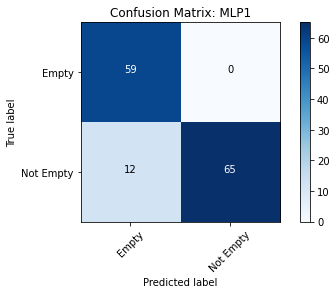

In [ ]:
cm_plot_labels = ['Empty','Not Empty']
cm = confusion_matrix(y_true=test_labels_DT, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix: MLP1')
print("Accuracy: ", accuracy_score(test_labels_DT, rounded_predictions))
print("Per class: ", cm.diagonal()/cm.sum(axis=1))

Confusion matrix, without normalization
[[59  0  0]
 [10 17 19]
 [ 4  6 21]]
Accuracy:  0.7132352941176471
Per class:  [1.         0.36956522 0.67741935]


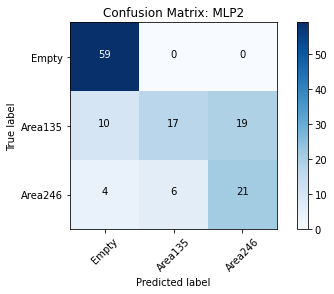

In [ ]:
cm_plot_labels_2 = ['Empty','Area135', 'Area246']
cm2 = confusion_matrix(y_true=test_labels_LC, y_pred=rounded_predictions_2)
plot_confusion_matrix(cm=cm2, classes=cm_plot_labels_2, title='Confusion Matrix: MLP2')
print("Accuracy: ", accuracy_score(test_labels_LC, rounded_predictions_2))
print("Per class: ", cm2.diagonal()/cm2.sum(axis=1))

Confusion matrix, without normalization
[[144 104]
 [ 10 422]]
Accuracy:  0.8323529411764706
Per class:  [0.58064516 0.97685185]


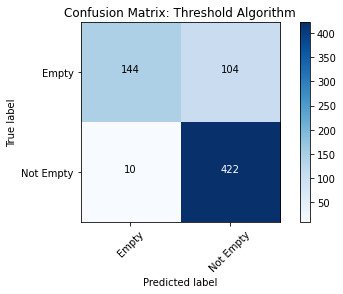

In [ ]:
cm3_plot_labels = ['Empty','Not Empty']
cm3 = confusion_matrix(y_true=detection_label, y_pred=detection_calc)
plot_confusion_matrix(cm=cm3, classes=cm3_plot_labels, title='Confusion Matrix: Threshold Algorithm')
print("Accuracy: ", accuracy_score(detection_label, detection_calc))
print("Per class: ", cm3.diagonal()/cm3.sum(axis=1))

# Saving model

## Model image

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model1.png', show_shapes=True, show_layer_activations=True, show_dtype=True)
plot_model(model_2, to_file='model2.png', show_shapes=True, show_layer_activations=True, show_dtype=True)

## Trained model

In [ ]:
# Saving model
model.save('./models/WirelessDt_MLP.h5')
model_2.save('./models/WirelessDt_CNN1D.h5')

## Download files

In [ ]:
from google.colab import files

In [ ]:
!zip -r WirelessDetection_DLModels.zip ./models
files.download("./WirelessDetection_DLModels.zip")

  adding: models/ (stored 0%)
  adding: models/WirelessDt_CNN1D.h5 (deflated 29%)
  adding: models/WirelessDt_MLP.h5 (deflated 35%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>